In [1]:
# Work done by Pritindra Bhowmick, EP-DT-DT, CERN during Summer Studentship 2021 at CERN.
# Project name: High precision calibration of 3D hall probes for magnet mapping apparatuses.
# Find me at pritindra2001@gmail.com, pritindra.bhowmick@cern.ch
# Find the project report at CERN CDS url coming soon
# History : Version 1: 04-09-2021

# ------------------------------------------------------------------------------
# 1 : importing packages
# ------------------------------------------------------------------------------

import numpy as np
from datetime import datetime

# ------------------------------------------------------------------------------
# 2 : Setting up angles and rotation arrays and matrices
# ------------------------------------------------------------------------------



#Azimuthal and Polar angles
def theta(x): return 6*x
def phi(x):   return 5*x+np.pi/12

#Rotation matrix
def Rot(x): return np.array([[np.cos(phi(x))*np.cos(theta(x)),-np.sin(phi(x)),np.sin(theta(x))*np.cos(phi(x))],
                             [np.sin(phi(x))*np.cos(theta(x)),np.cos(phi(x)),np.sin(theta(x))*np.sin(phi(x))],
                             [-np.sin(theta(x)),0,np.cos(theta(x))]])


# ------------------------------------------------------------------------------
# 3 : Making a model for hall voltage
# ------------------------------------------------------------------------------

I=1*10**(-2)   #current, we know this
R=200          #hall coefficient
G=1            #planar hall coefficient
tau = 4        #Non linearity parameter
mT = -0.003    #Temperature dependence

#Hall voltage
def V_hall(n,J,B,T): return  2*tau*(1-np.exp(-R*I*np.dot(n,B)/tau))/(1+np.exp(-R*I*np.dot(n,B)/tau)) 

#Planar Hall Voltage
def V_phe(n,J,B) : return 2*G*I * np.dot(J,B) * np.dot(np.cross(n,J),B) 

#output voltage from the hall probe
def V_out(n,J,B,T): return (1+np.sin(mT*T))*(V_hall(n,J,B,T)+V_phe(n,J,B))

# ------------------------------------------------------------------------------
# 4 : Introducing non-orthogonality
# ------------------------------------------------------------------------------

# Arbitrary angles of rotation
alpha = np.array([np.pi/51,np.pi/49,np.pi/55])
beta  = np.array([np.pi/44,np.pi/57,np.pi/55])
gamma = np.array([np.pi/45,np.pi/47,np.pi/53])

Rott = [np.array([[np.cos(alpha[i])*np.cos(beta[i]) , np.cos(alpha[i])*np.sin(beta[i])*np.sin(gamma[i]) - np.sin(alpha[i])*np.cos(gamma[i]) , np.cos(alpha[i])*np.sin(beta[i])*np.cos(gamma[i]) + np.sin(alpha[i])*np.sin(gamma[i])], 
                [np.sin(alpha[i])*np.cos(beta[i]) , np.sin(alpha[i])*np.sin(beta[i])*np.sin(gamma[i]) + np.cos(alpha[i])*np.cos(gamma[i]) , np.sin(alpha[i])*np.sin(beta[i])*np.cos(gamma[i]) - np.cos(alpha[i])*np.sin(gamma[i])],  
                [-np.sin(beta[i]) , np.cos(beta[i])*np.sin(gamma[i]) , np.cos(beta[i])*np.cos(gamma[i])]]) for i in range(3)]

# n and j values for 3 hall probes
n0 = [np.matmul([1,0,0],Rott[0]),np.matmul([0,1,0],Rott[1]),np.matmul([0,0,1],Rott[2])]
j0 = [np.matmul([0,1,0],Rott[0]),np.matmul([0,0,1],Rott[1]),np.matmul([1,0,0],Rott[2])]

xi=[[0.3399810435848563, 0.8611363115940526], [0.6612093864662645, 0.2386191860831969, 0.9324695142031520], 
    [0.1834346424956498, 0.5255324099163290, 0.7966664774136267, 0.9602898564975362], 
    [ 0.1488743389816312, 0.4333953941292472, 0.6794095682990244, 0.8650633666889845, 0.9739065285171717], 
    [ 0.1252334085114689, 0.3678314989981802, 0.5873179542866174, 0.7699026741943047, 0.9041172563704749,  0.9815606342467193]]

for type1 in ['A','B']:
    for order in range(3,7):
        
        #Number of points on the surface 
        iter = 240
        
        #angle array
        angle = np.linspace(0,2*np.pi,iter,endpoint=False)   # values of angle t

        
        # If type1 =='A' linear magnetic field scaling
        # If type1 =='B' Legendre Roots fields        
        # number of Roots of Legendre polynomials in positive x axis 
        
        # ------------------------------------------------------------------------------
        # 5 : Setting up magnetic field values for 3D scan
        # ------------------------------------------------------------------------------

        if type1 =='A': 
            # List of magnetic field values to scan
            if order ==3:  B0_list = [0.5,1.5,2.5]
            if order ==4:  B0_list = [0.625,1.25,1.85,2.5]
            if order ==5:  B0_list = [0.5,1.0,1.5,2.0,2.5]
            if order ==6:  B0_list = [0.42,0.84,1.26,1.68,2.10,2.52]            
            B_max = B0_list[-1]

        if type1 =='B':
            # Maximum magnetic field to be scaled
            B_max = 2.5
            B0_list = B_max * np.array(xi[order-2])
        
        print(type1,order,B0_list)

        # B0_list os the listof magnetic fields used for 3D scanning
        B0_list = np.array([[0,0,B0] for B0 in B0_list])

        # Two temperatures for scanning
        T0 = 20
        T1 = 25

        # ------------------------------------------------------------------------------
        # 6 : Wrting output voltages on a file for reading
        # ------------------------------------------------------------------------------

        filename = 'result'+str(type1)+str(order)

        sourceFile = open(filename+'Voltages.csv', 'w')

        print(type1+'\n'+str(iter)+','+str(I),file = sourceFile)
        for B0 in B0_list:
            print(str(B0[2])+',',file = sourceFile,end = '')
        print('\n'+str(T0)+','+str(T1),file = sourceFile)
        print(str(order)+','+str(B_max),file = sourceFile)

        for B0 in B0_list:
            print('#  B = '+str(B0[2])+' \t T = '+str(T0)+' \t Date and time '+str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")), file = sourceFile)
            for t in angle:
                Rr=Rot(t)
                n1,n2,n3 = np.matmul(n0,Rr)
                j1,j2,j3 = np.matmul(j0,Rr)
                string = str(V_out(n1,j1,B0,T0))+','+str(V_out(n2,j2,B0,T0))+','+str(V_out(n3,j3,B0,T0))
                print(string, file = sourceFile)
        B0 = B0_list[-1]
        print('#  B = '+str(B0[2])+' \t T = '+str(T1)+' \t Date and time '+str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")), file = sourceFile)
        for t in angle:
            Rr=Rot(t)
            n1,n2,n3 = np.matmul(n0,Rr)
            j1,j2,j3 = np.matmul(j0,Rr)
            string = str(V_out(n1,j1,B0,T1))+','+str(V_out(n2,j2,B0,T1))+','+str(V_out(n3,j3,B0,T1))
            print(string, file = sourceFile)
            
        del sourceFile


A 3 [0.5, 1.5, 2.5]
A 4 [0.625, 1.25, 1.85, 2.5]
A 5 [0.5, 1.0, 1.5, 2.0, 2.5]
A 6 [0.42, 0.84, 1.26, 1.68, 2.1, 2.52]
B 3 [1.65302347 0.59654797 2.33117379]
B 4 [0.45858661 1.31383102 1.99166619 2.40072464]
B 5 [0.37218585 1.08348849 1.69852392 2.16265842 2.43476632]
B 6 [0.31308352 0.91957875 1.46829489 1.92475669 2.26029314 2.45390159]


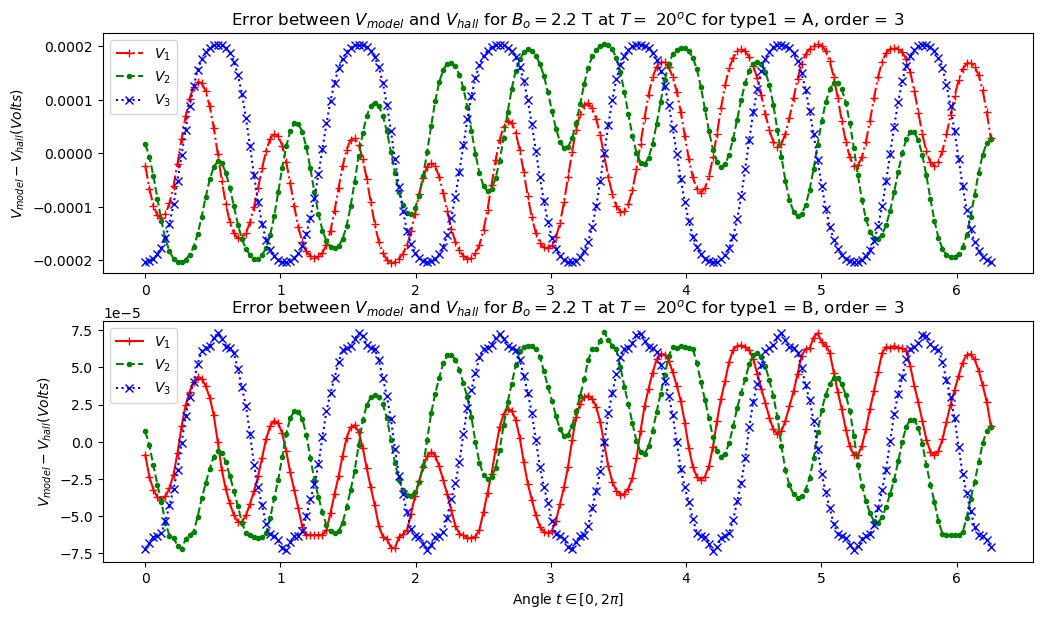

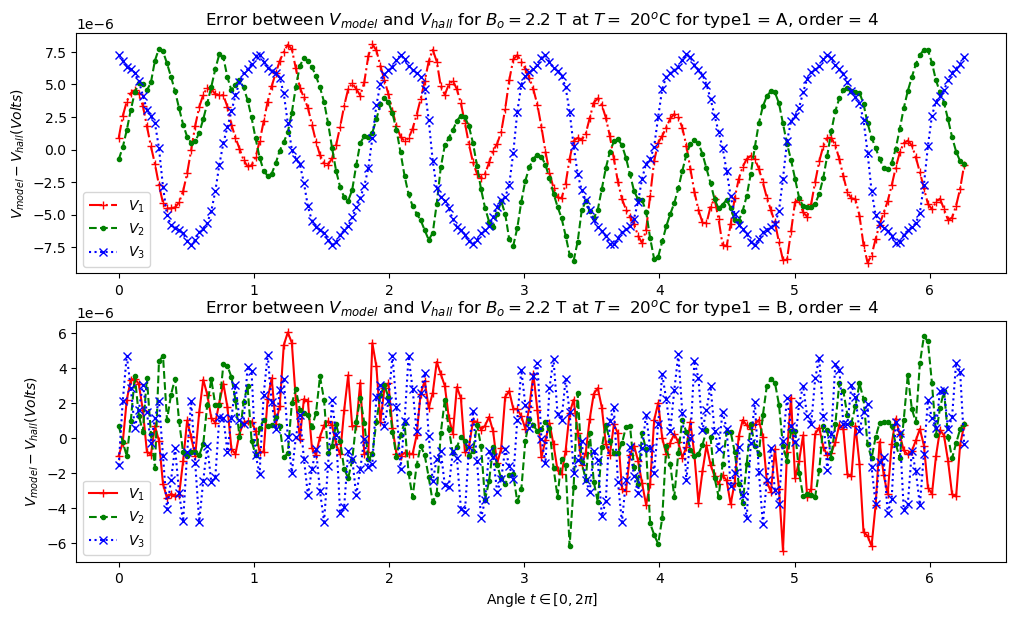

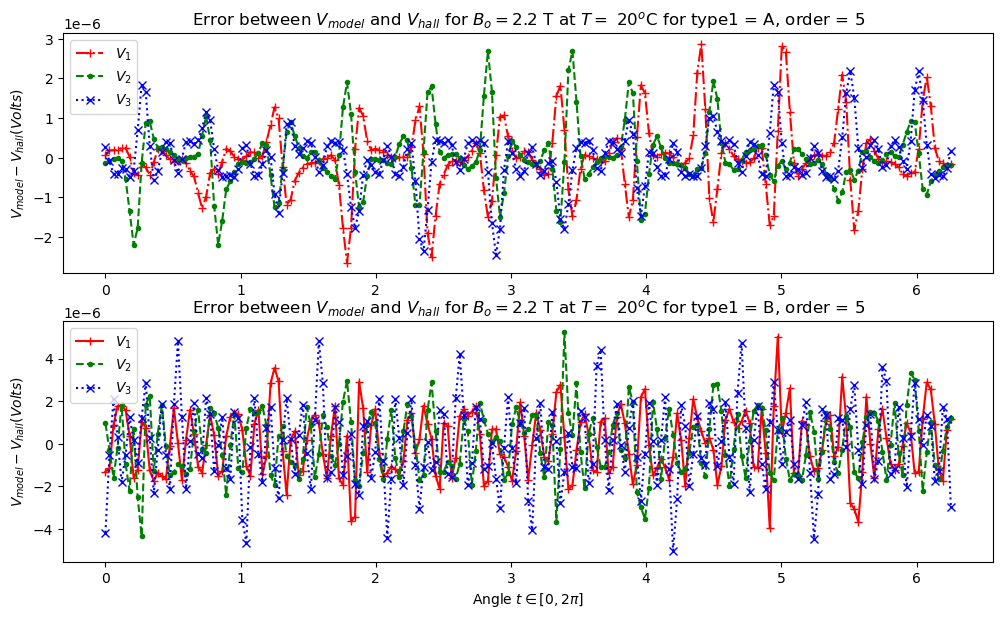

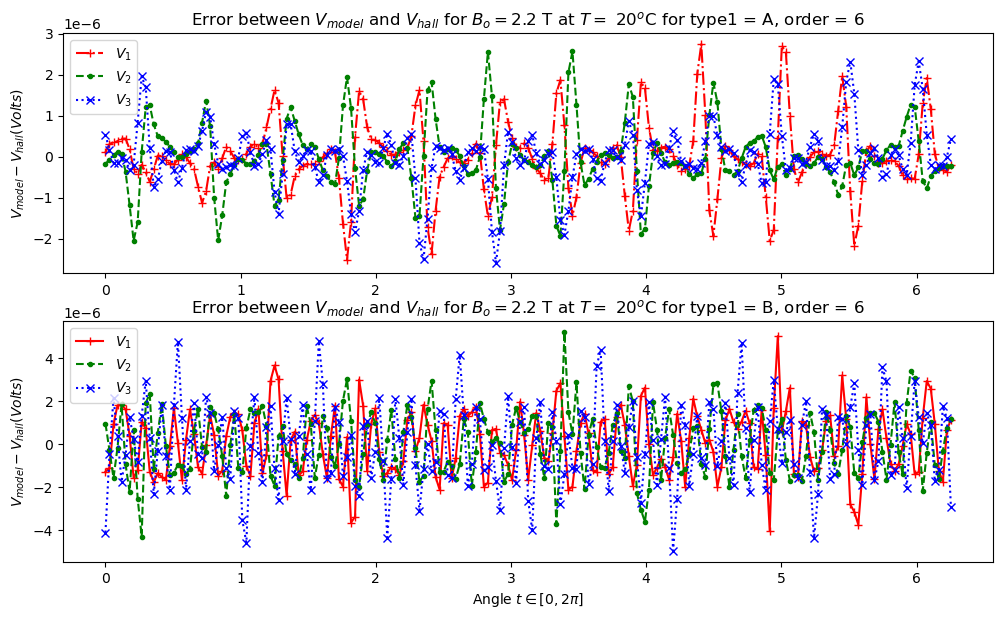

In [6]:
import numpy as np

#Number of points on the surface 
iter = 211

#angle array
angle = np.linspace(0.001,2*np.pi,iter,endpoint=False)   # values of angle t

Blist = []
Vlist = []

B0 = np.array([0,0,2.2])
T0 = 20
for t in angle:
    Br = np.matmul(Rot(t),B0.transpose())
    Blist.append(list(Br.transpose()))
    Vlist.append([V_out(n0[j],j0[j],Br,T0) for j in range(3)])


import HallCalibration as hc
import matplotlib.pyplot as plt

for order in range(3,7):

    fn = 'resultA'+str(order)
    hc.scan_3D(fn)
    Vout = []

    for i in range(iter):
        B0 = Blist[i]
        V = hc.findVmodel(fn,B0,T0)
        Vout.append(V)
        

    VerrorA = [[Vout[i][j]-Vlist[i][j] for i in range(iter)] for j in range(3)]

    fn = 'resultB'+str(order)
    hc.scan_3D(fn)
    Vout = []

    for i in range(iter):
        B0 = Blist[i]
        V = hc.findVmodel(fn,B0,T0)
        Vout.append(V)

    VerrorB = [[Vout[i][j]-Vlist[i][j] for i in range(iter)] for j in range(3)]


    plt.figure(figsize=(12, 7),dpi=100)
    plt.subplot(2,1,1)
    plt.plot(angle,VerrorA[0],'r+-.')
    plt.plot(angle,VerrorA[1],'g.--')
    plt.plot(angle,VerrorA[2],'bx:')
    plt.ylabel('$V_{model}-V_{hall}   (Volts)$')
    plt.title('Error between $V_{model}$ and $V_{hall}$ for $B_o = 2.2$ T at $T = $ '+str(T0)+'$^o$C for type1 = A, order = '+str(order))
    plt.legend(['$V_1$','$V_2$','$V_3$'])
    
    plt.subplot(2,1,2)
    plt.plot(angle,VerrorB[0],'r+-')
    plt.plot(angle,VerrorB[1],'g.--')
    plt.plot(angle,VerrorB[2],'bx:')
    plt.xlabel('Angle $t\in[0,2\pi]$')
    plt.ylabel('$V_{model}-V_{hall}   (Volts)$')
    plt.title('Error between $V_{model}$ and $V_{hall}$ for $B_o = 2.2$ T at $T = $ '+str(T0)+'$^o$C for type1 = B, order = '+str(order))
    plt.legend(['$V_1$','$V_2$','$V_3$'])
    plt.show()


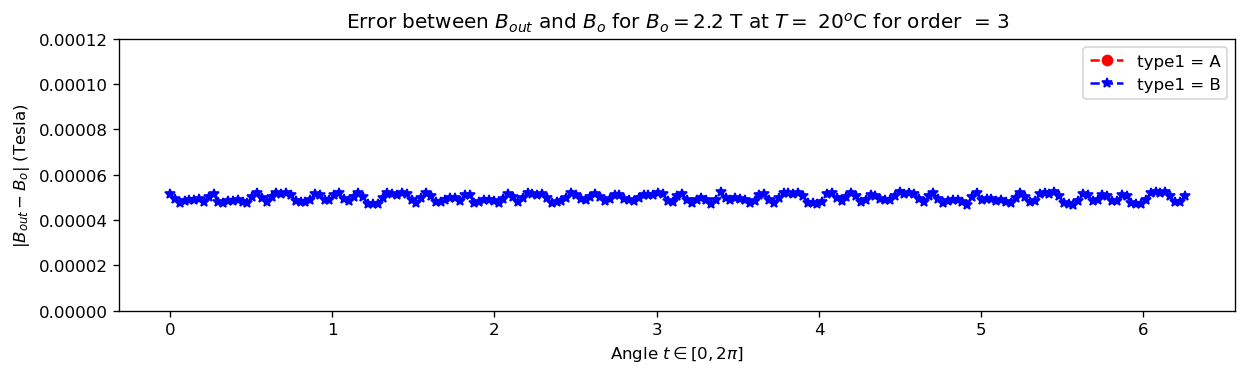

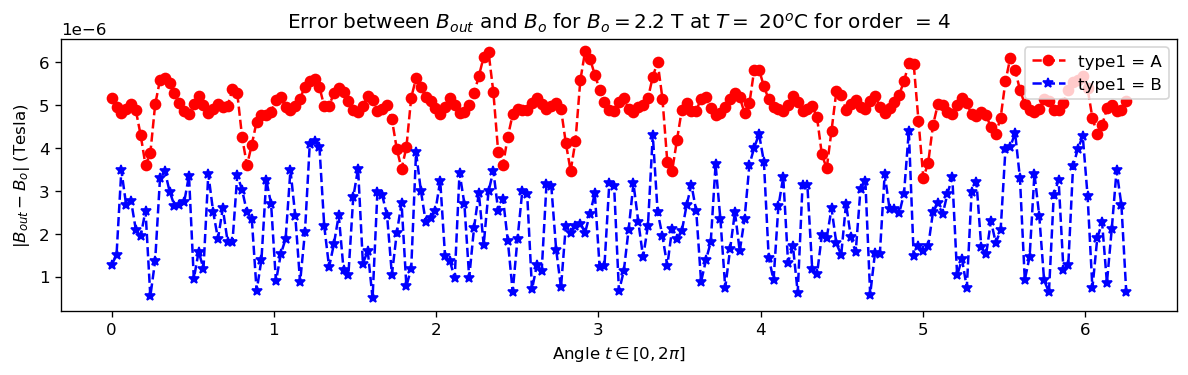

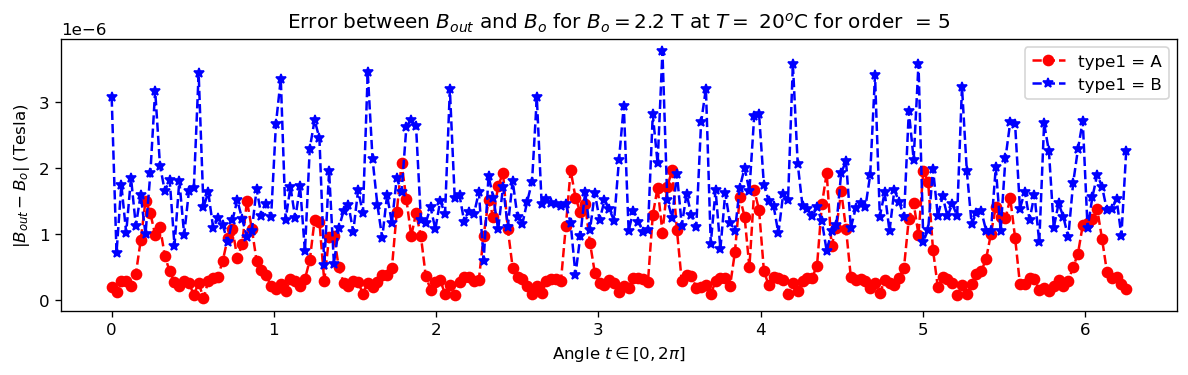

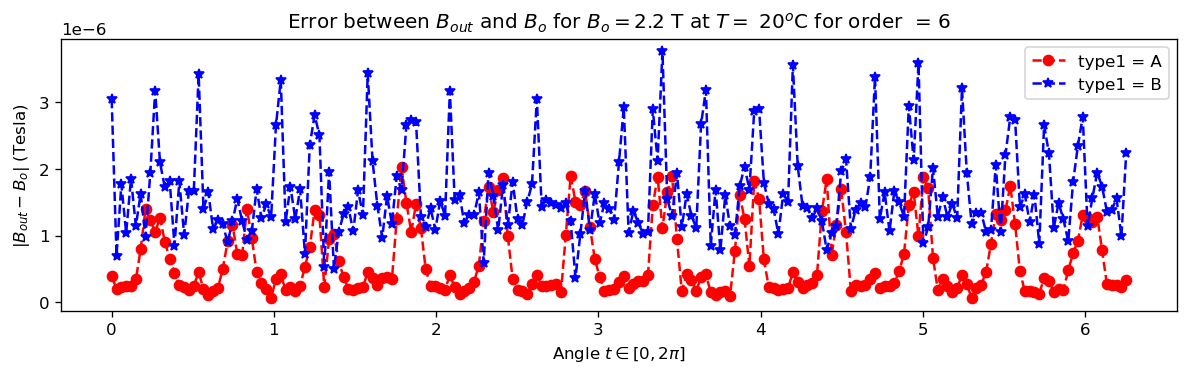

In [7]:
Bmeo = [[],[]]

for order in range(3,7):

    fn = 'resultA'+str(order)
    T0 = 20
    Bout = []

    for i in range(iter):
        V = Vlist[i]
        B0 = Blist[i]
        B = hc.findB(fn,V,T0)
        Bout.append(B)

    BerrorA = [np.linalg.norm(Bout[i]-Blist[i]) for i in range(iter)]

    fn = 'resultB'+str(order)
    Bout = []

    for i in range(iter):
        V = Vlist[i]
        B0 = Blist[i]
        B = hc.findB(fn,V,T0)
        Bout.append(B)

    BerrorB = [np.linalg.norm(Bout[i]-Blist[i]) for i in range(iter)]

    plt.figure(figsize=(12, 3),dpi=120)
    plt.plot(angle,1*np.array(BerrorA),'ro--')
    plt.plot(angle,BerrorB,'b*--')
    plt.xlabel('Angle $t\in[0,2\pi]$')
    plt.ylabel('$|B_{out}-B_o|$ (Tesla)')
    plt.title('Error between $B_{out}$ and $B_o$ for $B_o = 2.2$ T at $T = $ '+str(T0)+'$^o$C for order  = '+str(order))
    plt.legend(['type1 = A','type1 = B'])
    Bmeo[0].append(max(BerrorA))
    Bmeo[1].append(max(BerrorB))
    if order == 3: plt.ylim([0,0.00012])
    plt.show()



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


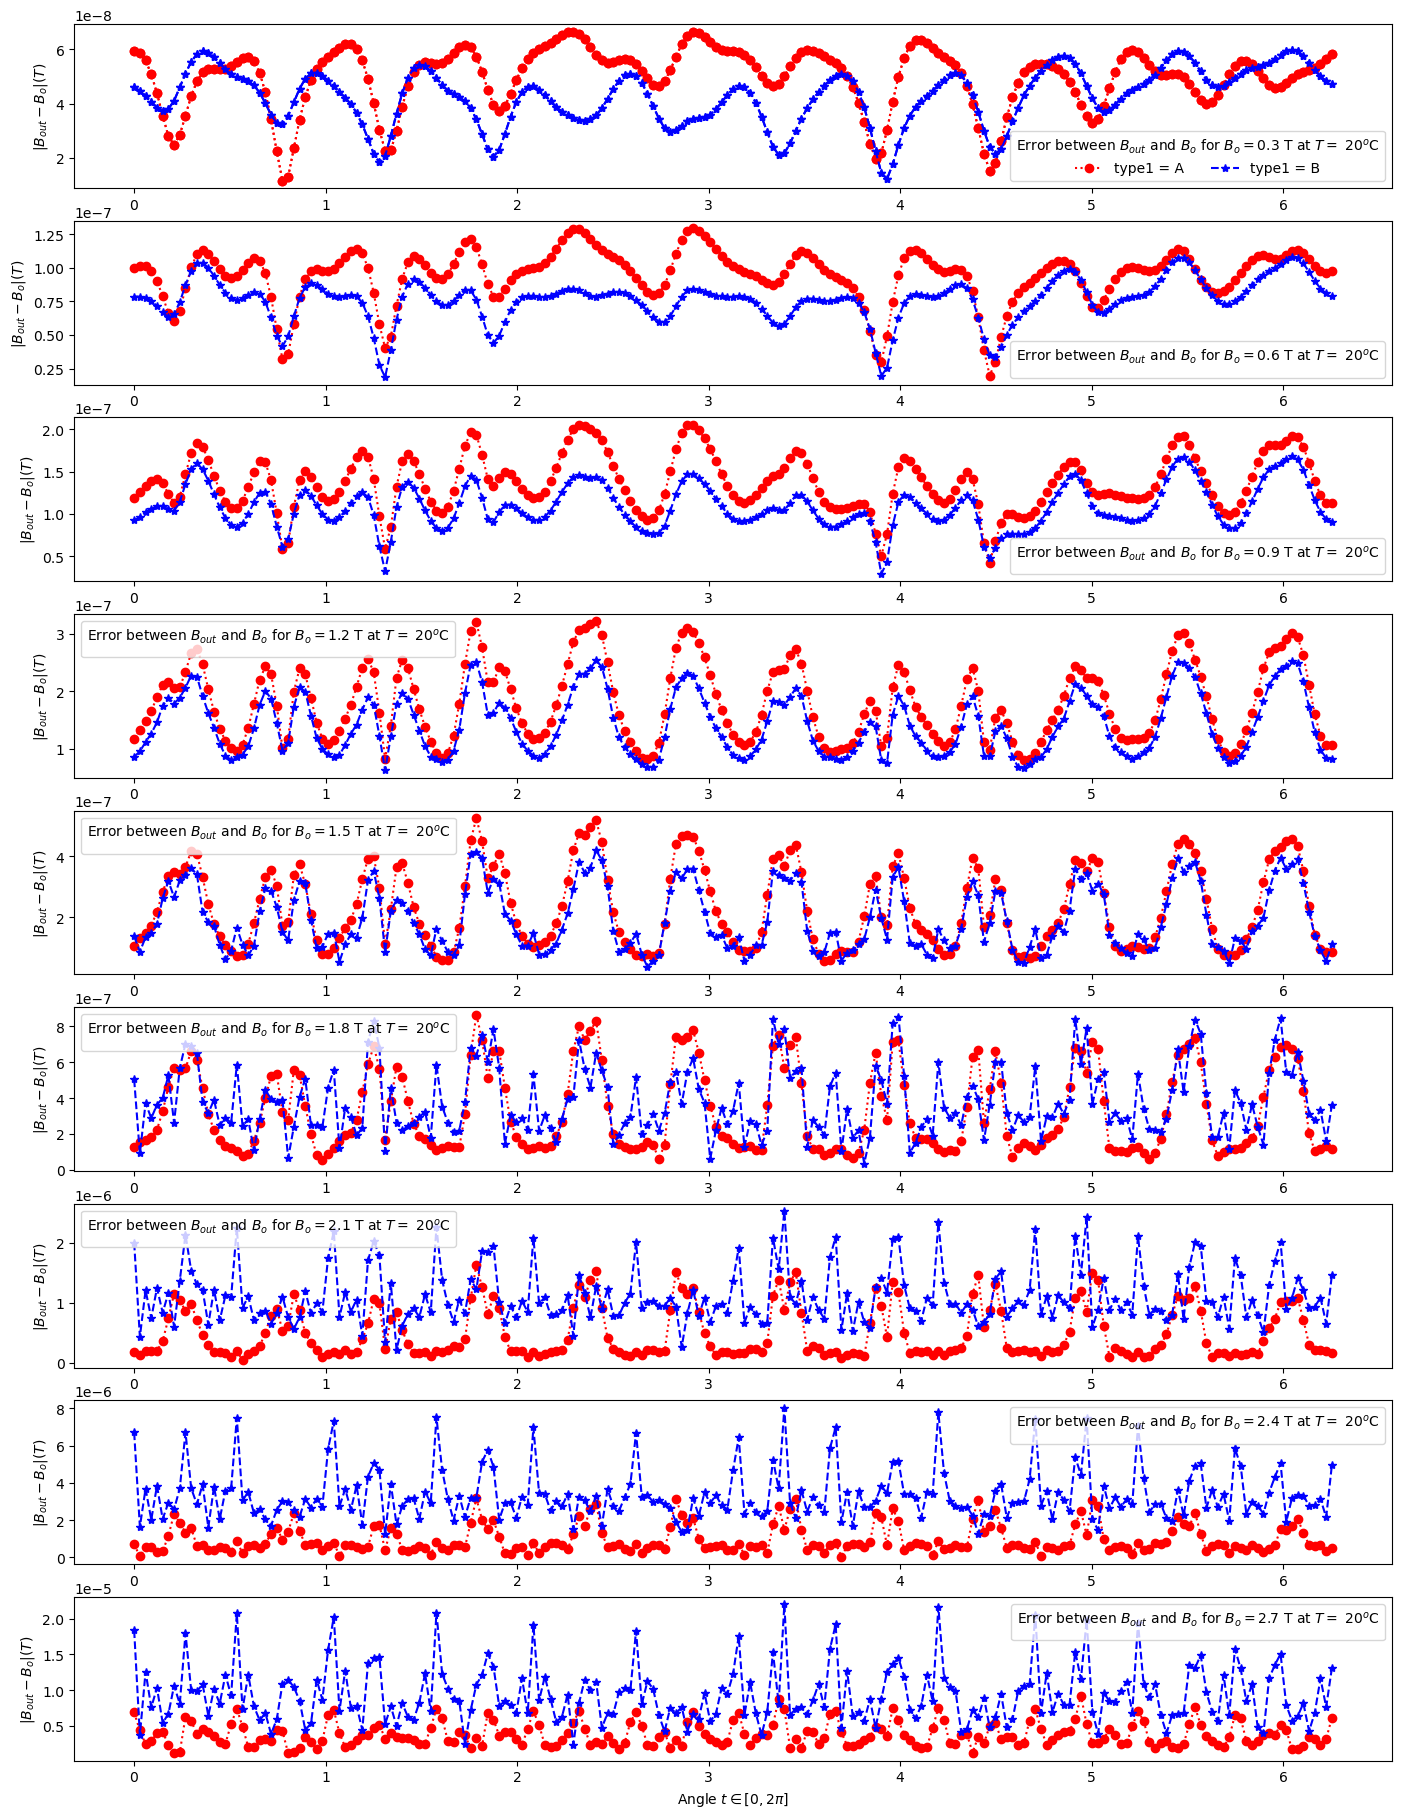

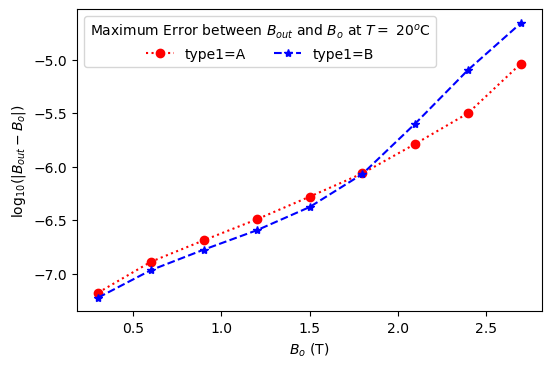

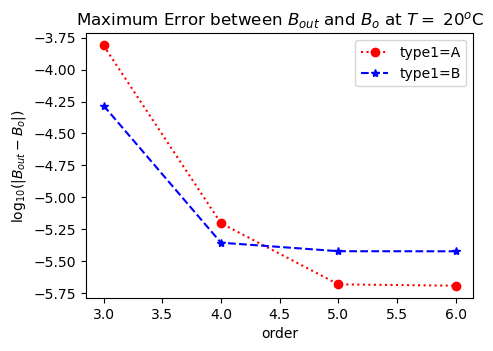

In [8]:
B0 = [0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7]
T0 = 20
BerrA = [[] for j in B0]
BerrB = [[] for j in B0]
for i in range(9):
    B=B0[i]
    for t in angle:
        Br = np.matmul(Rot(t),[0,0,B]).transpose()
        V=[V_out(n0[j],j0[j],Br,T0) for j in range(3)]
        Bout1 = hc.findB('resultA5',V,T0)
        BerrA[i].append(np.linalg.norm(Br-Bout1))
        Bout2 = hc.findB('resultB5',V,T0)
        BerrB[i].append(np.linalg.norm(Br-Bout2))

plt.figure(figsize=(17, 23),dpi = 100)

for i in range(len(B0)):
    plt.subplot(9,1,i+1)
    B=B0[i]
    if i == 0: 
        plt.plot(angle,BerrA[i],'ro:',label = 'type1 = A')
        plt.plot(angle,BerrB[i],'b*--',label = 'type1 = B')
    plt.plot(angle,BerrA[i],'ro:')
    plt.plot(angle,BerrB[i],'b*--')
    plt.ylabel('$|B_{out}-B_o|(T)$')
    plt.legend(title = 'Error between $B_{out}$ and $B_o$ for $B_o = $'+str(B)+' T at $T = $ '+str(T0)+'$^o$C', ncol = 2)
plt.xlabel('Angle $t\in[0,2\pi]$')
plt.show()

plt.figure(figsize=(6, 4),dpi = 100)
plt.plot(B0,[np.log10(max(b)) for b in BerrA],'ro:',label = 'type1=A')
plt.plot(B0,[np.log10(max(b)) for b in BerrB],'b*--',label = 'type1=B')
plt.ylabel('$\log_{10}(|B_{out}-B_o|)$')
plt.legend(title = 'Maximum Error between $B_{out}$ and $B_o$ at $T = $ '+str(T0)+'$^o$C', ncol = 2)
plt.xlabel('$B_o$ (T)')
plt.show()

plt.figure(figsize=(5, 3.5),dpi = 100)
plt.plot([3,4,5,6],np.log10(np.array(Bmeo[0])),'ro:',label = 'type1=A')
plt.plot([3,4,5,6],np.log10(np.array(Bmeo[1])),'b*--',label = 'type1=B')
plt.ylabel('$\log_{10}(|B_{out}-B_o|)$')
plt.legend()
plt.title('Maximum Error between $B_{out}$ and $B_o$ at $T = $ '+str(T0)+'$^o$C')
plt.xlabel('order')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


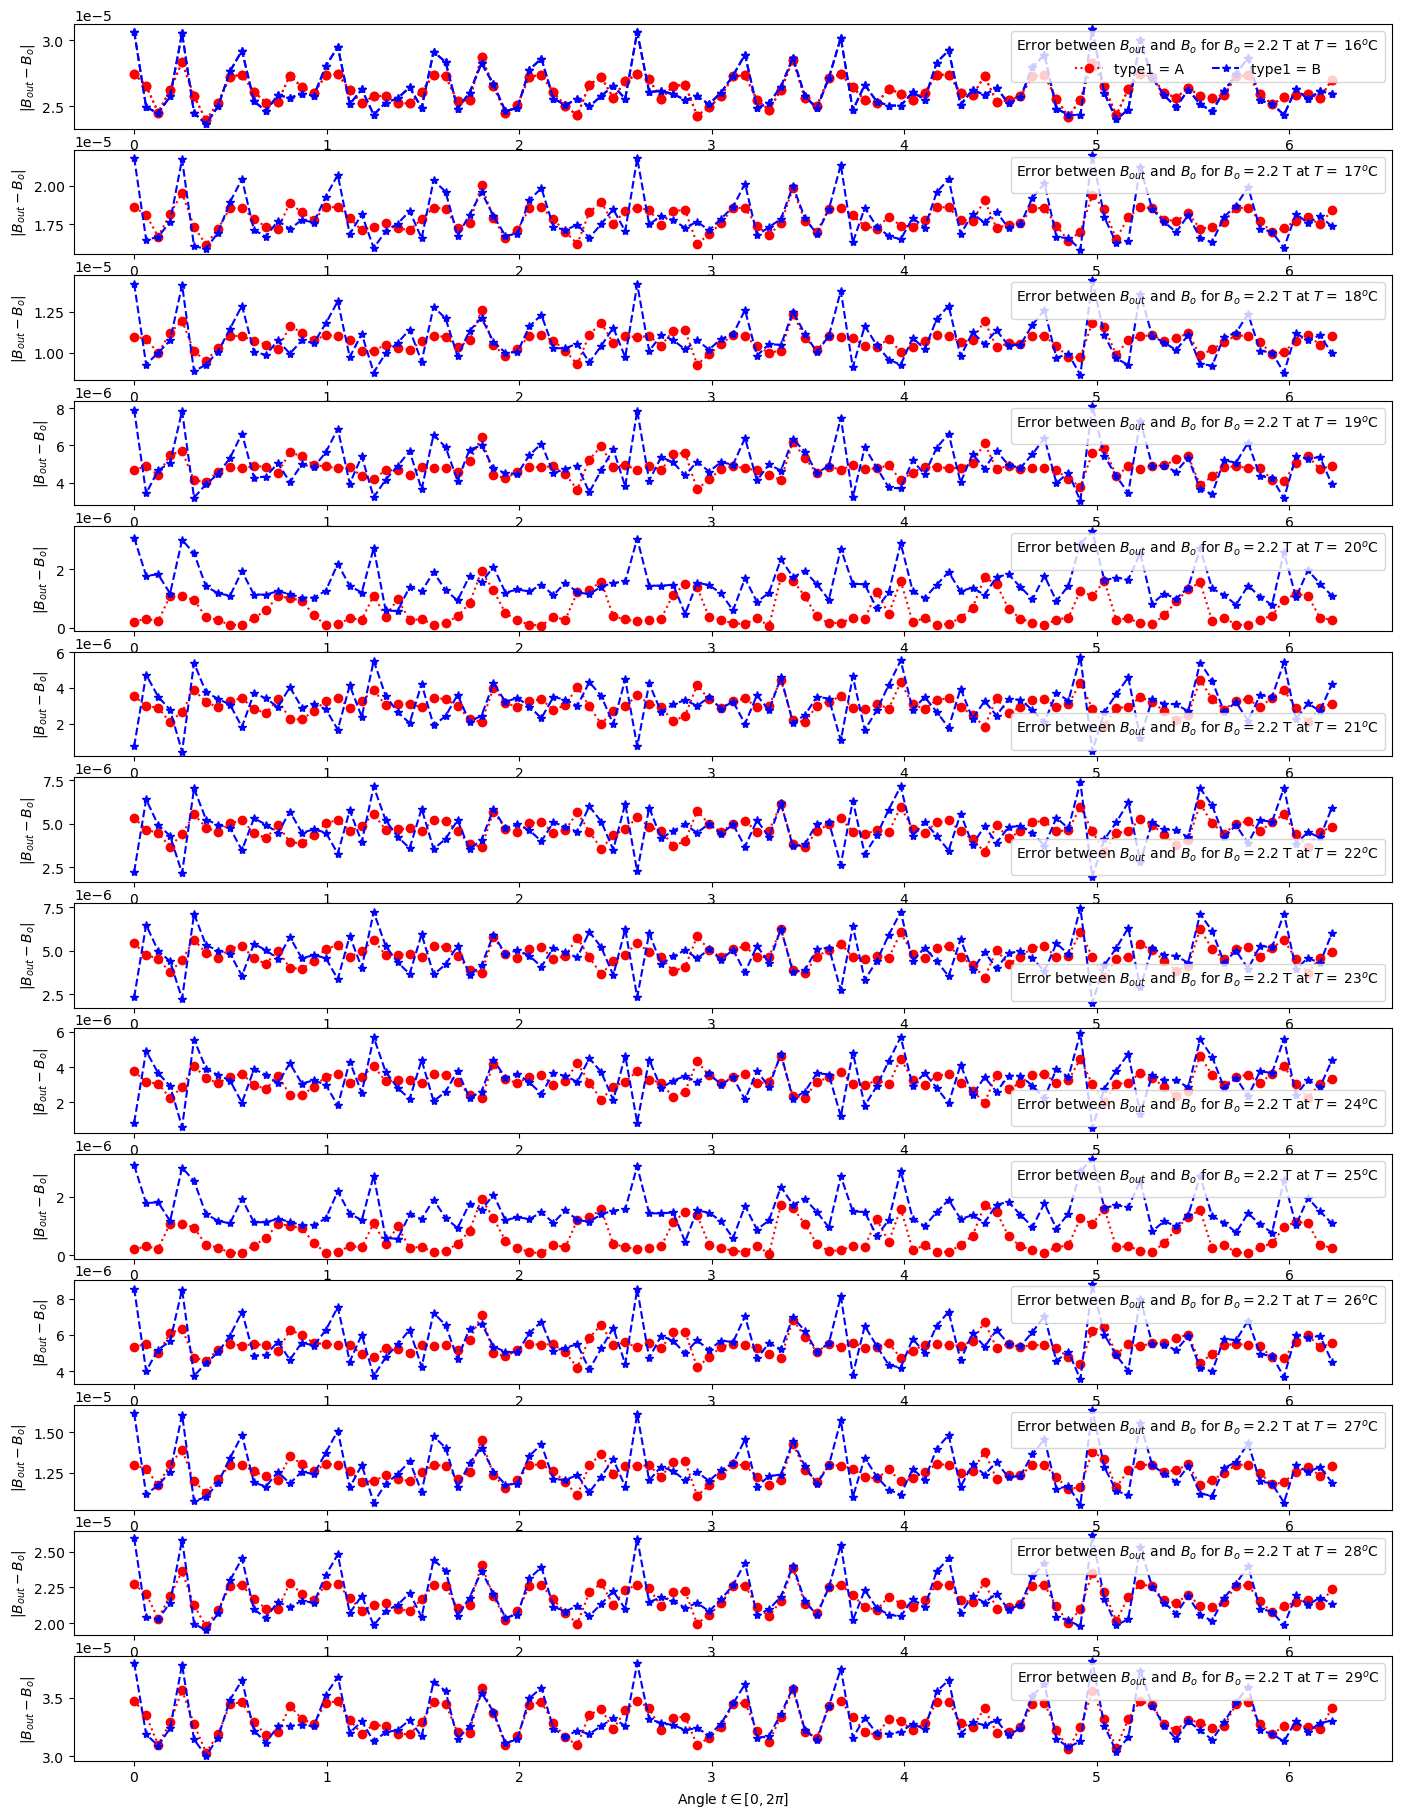

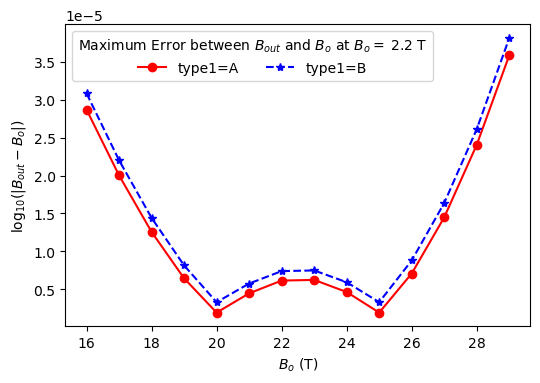

In [10]:
import HallCalibration as hc
import matplotlib.pyplot as plt

hc.scan_3D('resultA5')
hc.scan_3D('resultB5')

angle = np.linspace(0.001,2*np.pi,101,endpoint=False)

B0 = 2.2
T0 = [16,17,18,19,20,21,22,23,24,25,26,27,28,29]
TerrA = [[] for j in T0]
TerrB = [[] for j in T0]
for i in range(len(T0)):
    T = T0[i]
    for t in angle:
        Br = np.matmul(Rot(t),[0,0,B0]).transpose()
        V=[V_out(n0[j],j0[j],Br,T) for j in range(3)]
        Bout1 = hc.findB('resultA5',V,T)
        TerrA[i].append(np.linalg.norm(Br-Bout1))
        Bout2 = hc.findB('resultB5',V,T)
        TerrB[i].append(np.linalg.norm(Br-Bout2))

        
plt.figure(figsize=(17, 23),dpi=100)

for i in range(len(T0)):
    plt.subplot(len(T0),1,i+1)
    T=T0[i]
    if i == 0: 
        plt.plot(angle,TerrA[i],'ro:',label = 'type1 = A')
        plt.plot(angle,TerrB[i],'b*--',label = 'type1 = B')
    plt.plot(angle,TerrA[i],'ro:')
    plt.plot(angle,TerrB[i],'b*--')
    plt.ylabel('$|B_{out}-B_o|$')
    plt.legend(title = 'Error between $B_{out}$ and $B_o$ for $B_o = $'+str(B0)+' T at $T = $ '+str(T)+'$^o$C', ncol = 2)
plt.xlabel('Angle $t\in[0,2\pi]$')
plt.show()



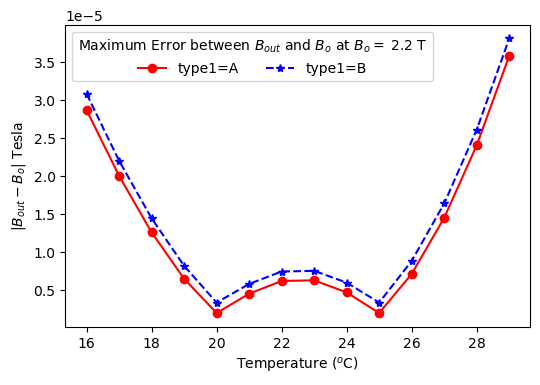

In [12]:
plt.figure(figsize=(6, 4),dpi = 100)
plt.plot(T0,[(max(b)) for b in TerrA],'ro-',label = 'type1=A')
plt.plot(T0,[(max(b)) for b in TerrB],'b*--',label = 'type1=B')
plt.ylabel('$|B_{out}-B_o|$ Tesla')
plt.legend(title = 'Maximum Error between $B_{out}$ and $B_o$ at $B_o = $ '+str(B0)+' T', ncol = 2)
plt.xlabel('Temperature ($^o$C)')
plt.show()